About data
Smarphones and smartwatches contain tri-axial accelerometers that measure acceleration in all three spatial dimensions. These accelerometers are capable of detecting the orientation of the device, which can provide useful information for activity recognition.

The dataset that we are going to use for this demonstration is sourced from WISDM Lab, Department of Computer & Information Science, Fordham University, Bronx, NY (Link to the dataset). Note that the file that we are going to use is the raw data file — WISDM_ar_v1.1_raw.txt

This data is collected from 36 different users as they performed some common human activities such as — walking, jogging, ascending stairs, descending stairs, sitting, and standing for specific periods of time. In all cases, the data is collected every 50 millisecond, that is 20 samples per second.

There are total of 5 feature variables— ‘user’, ‘timestamp’, ‘x-axis’, ‘y-axis’, and ‘z-axis’. The target variable is ‘activity’ which we intend to predict.

‘user’ denotes the user ID, ‘timestamp’ is the unix timestamp in nanoseconds, and the rest are the accelerometer readings along the x, y, and z axes/dimensions at a given time.
Here is the glimpse of how the raw dataset looks —

# Data Cleaning and Preprocessing
We execute the following steps based on the observation —
* drop null values.
* change the datatype of the ‘z-axis’ column to float.
* drop the rows where the timestamp is 0.
* sort data in ascending order of the user and timestamp.

In [1]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
har_df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [2]:
har_df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [3]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [4]:
# removing null values
har_df = har_df.dropna()
har_df.shape

# transforming the z-axis to float
har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))


# drop the records where timestamp = 0
df = har_df[har_df['timestamp'] != 0]
print(df.shape)

# now arrange data in ascending order of the User and timestamp
df_sorted = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)
df_sorted

(1085360, 6)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085360 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1085360 non-null  int64  
 1   activity   1085360 non-null  object 
 2   timestamp  1085360 non-null  int64  
 3   x-axis     1085360 non-null  float64
 4   y-axis     1085360 non-null  float64
 5   z-axis     1085360 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


# Exploratory Data Analysis


In [6]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [7]:
label_dict = dict(har_df['activity'].value_counts())
label_dict

{'Walking': 424397,
 'Jogging': 342176,
 'Upstairs': 122869,
 'Downstairs': 100427,
 'Sitting': 59939,
 'Standing': 48395}

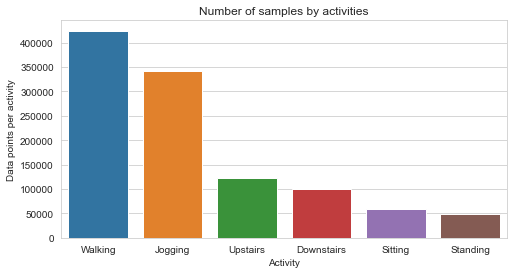

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of data points in class Walking = 424397 ~ 38.64%
Number of data points in class Jogging = 342176 ~ 31.16%
Number of data points in class Upstairs = 122869 ~ 11.19%
Number of data points in class Downstairs = 100427 ~ 9.14%
Number of data points in class Sitting = 59939 ~ 5.46%
Number of data points in class Standing = 48395 ~ 4.41%
--------------------------------------------------
total datapoints: 1098203


In [8]:
# analysis of class labels

sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = list(label_dict.keys()), y = list(label_dict.values()))
plt.xlabel('Activity')
plt.ylabel('Data points per activity')
plt.title('Number of samples by activities')
plt.show()

# Percentage-wise distribution of the class label yi's
print("- "* 50)
for i in label_dict.keys():
  print("Number of data points in class {0} = {1} ~ {2}%".format(
  i, label_dict[i], round((label_dict[i]*100)/sum(label_dict.values()), 2)))

print("-"*50)
print("total datapoints:", sum(label_dict.values()))

As you can see there is a significant class imbalance here with majority of the samples having class-label ‘Walking’ and ‘Jogging’. ‘Standing and ‘Sitting’ activities have least representation in the dataset.

### Data per User


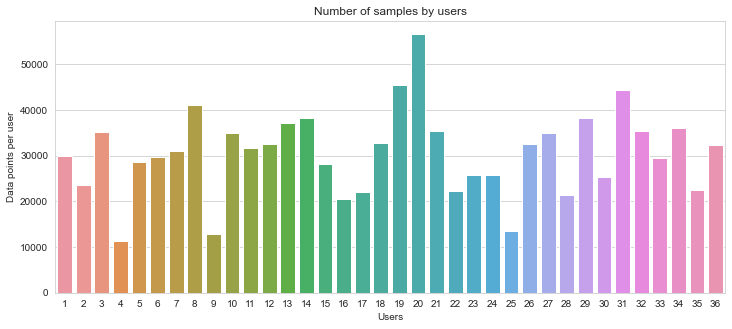

In [9]:
# User analysis

label_dict = dict(har_df['user'].value_counts())

sns.set_style("whitegrid")
plt.figure(figsize = (12, 5))
sns.barplot(x = list(label_dict.keys()), y = list(label_dict.values()))
plt.xlabel('Users')
plt.ylabel('Data points per user')
plt.title('Number of samples by users')
plt.show()

### User analysis: activity-wise

Now let’see how the users are contributing to each activity. This will help us in deciding how to split the data for training and testing.

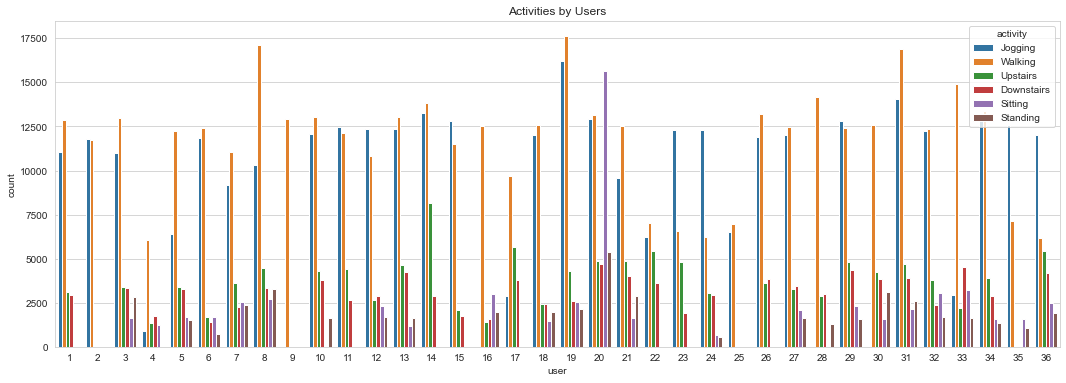

In [10]:
# User analysis: activity-wise

plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = har_df)
plt.title('Activities by Users')
plt.show()

As it can be seen, not all the users are performing all the activities. The time for which they perform each activity also varies. Regardless, this won’t be affecting our subsequent analysis as we have sufficiently large number of data samples and we are assuming all the users are alike.

### Analysis of Signals


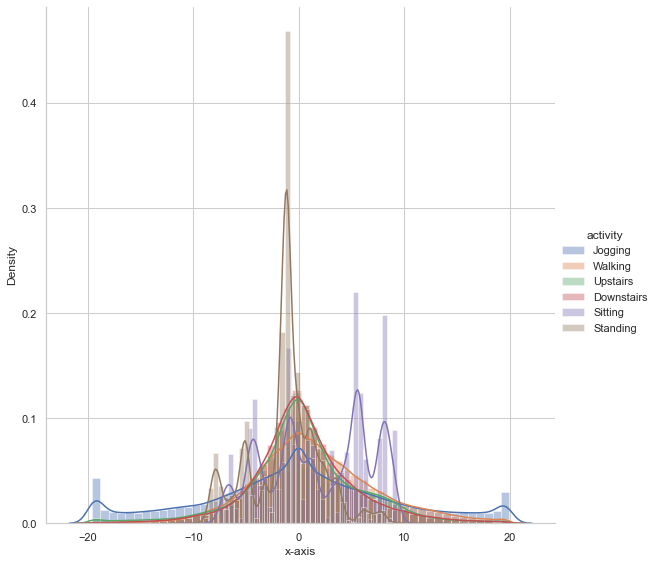

In [11]:
# x-axis

sns.set(style = 'whitegrid')
sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'x-axis').add_legend()
plt.show()

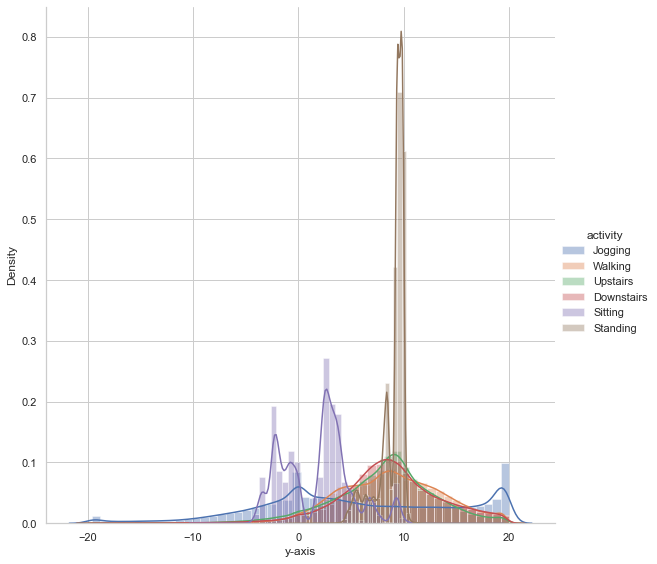

In [12]:
# y-axis

sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'y-axis').add_legend()
plt.show()

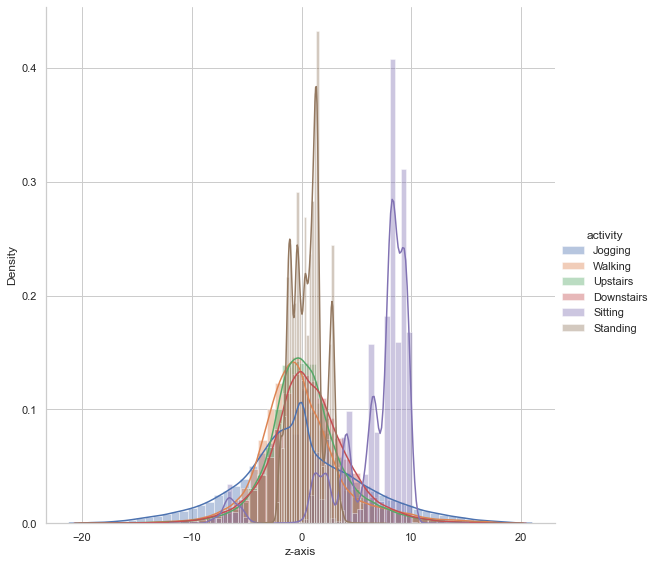

In [13]:
# z-axis

sns.FacetGrid(har_df, hue = 'activity', height = 8).map(sns.distplot, 'z-axis').add_legend()
plt.show()

It is observed that there is very high overlap in the data among activities like Upstairs, Downstairs, Walking, Jogging and Standing on all the axes. Sitting somewhat appears to have distinctive values along y-axis and z-axis.

This bring us to the heart of the article, that is Data transformation and Feature engineering.

For a particular user, lets observe how the signal values in each of the x, y and z dimension varies with time.

In [14]:
def plot_activity(activity):
    data = har_df[har_df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:400]
    axis = data["x-axis"].plot(subplots=True, color="b", fontsize = 12)
    axis = data["y-axis"].plot(subplots=True, color="r", fontsize = 12)
    axis = data["z-axis"].plot(subplots=True, color="g", fontsize = 12)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5), fontsize = 12)



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Downstairs -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




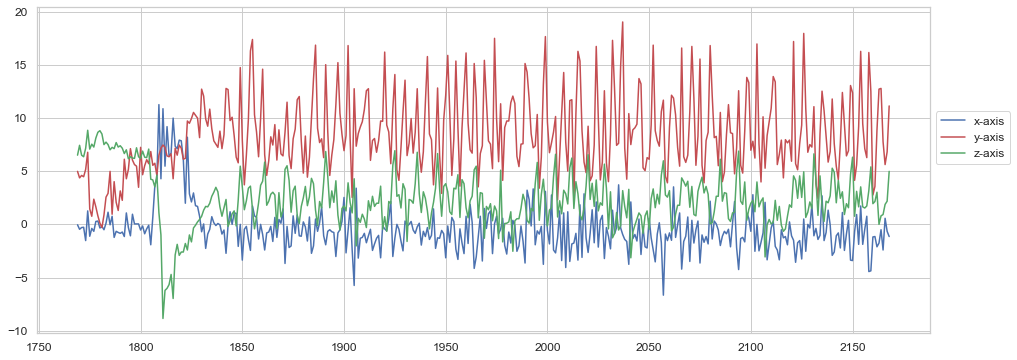



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Jogging -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




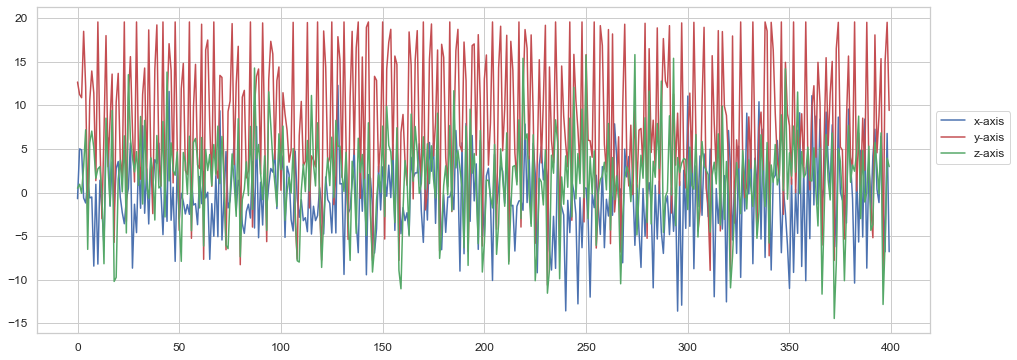



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Sitting -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




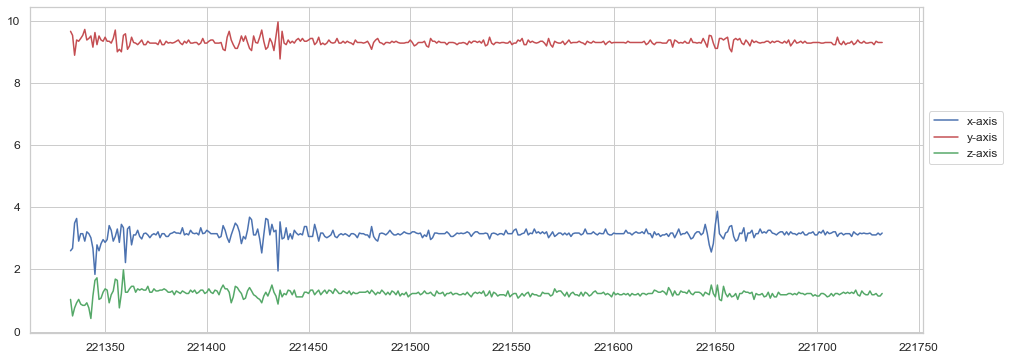



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Standing -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




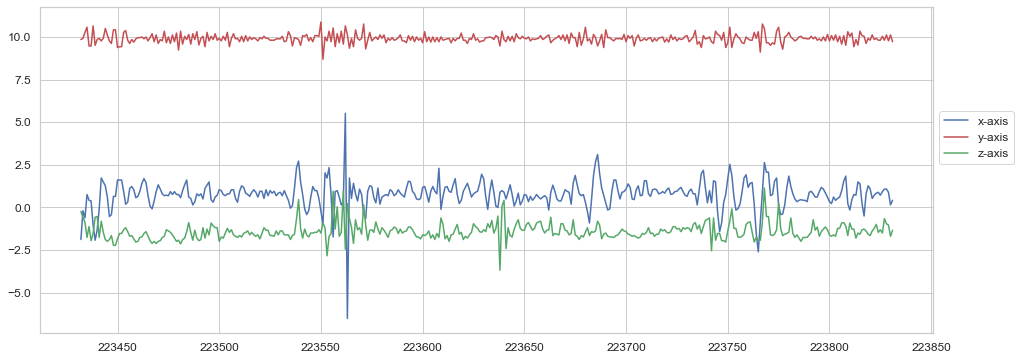



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Upstairs -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




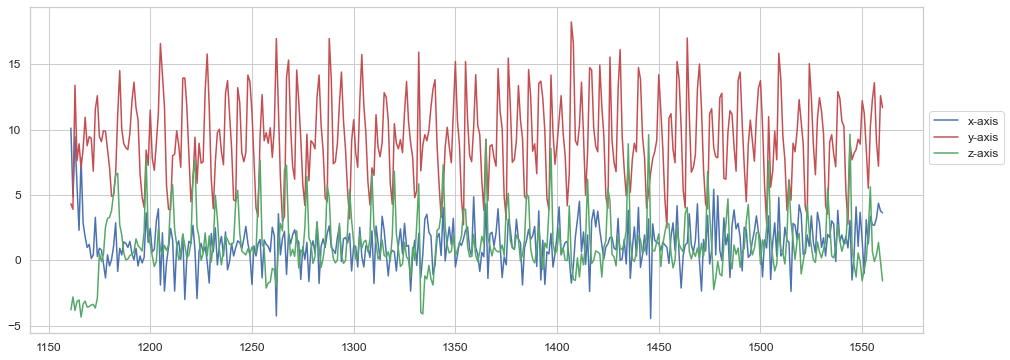



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Walking -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




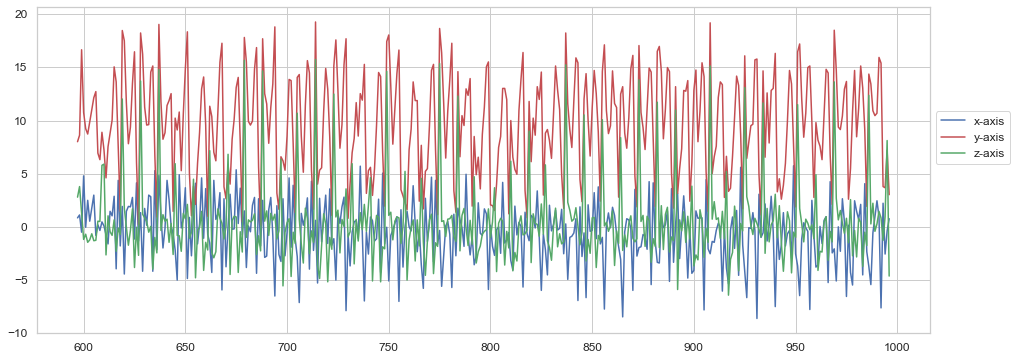

In [15]:
for i in np.unique(har_df['activity'].values):
    plt.figure(figsize = (16, 6))
    print("\n")
    print(" - "*15 + str(i) + " - "*15)
    print("\n")
    plot_activity(i)
    plt.show()

We have considered a subset of 400 samples for visualising the signal. This is equivalent to 20 secs of the activity (as the frequency of data collection was 20 Hz). As you can notice, the signals shows periodic behaviour for the activities like Walking, Jogging, Upstairs and Downstairs while it has very less movement for stagnant activities like Sitting and Standing.

# Data Transformation


Standard classification algorithms cannot be directly applied to the raw time-series data. Instead, we must first transform the raw time-series data using ‘windowing’ technique. In this technique, we divide the data into windows of 5 seconds, and then we generate new features by aggregating the 100 raw samples contained within each of these 5 second segments. For assigning class-label against the transformed features, we take the most frequent activity in that window.


For example, let’s say a raw dataset has 100 rows of sequential data. So after windowing and aggregation (using window size = 50), it will be transformed into 2 rows. The class-label assigned for these 2 new rows will be the most frequent activity in the respective window. Likewise, for 1 million rows, we will be getting nearly a total of 20k rows in transformed set.


You must be wondering why a 5 sec window is chosen. After going through several literature, I felt that it could be the optimal window-size we can consider for capturing the repetitive motions involved in most of the six activities. Too less window-size may not capture the motion correctly, while too large window-size results in less datapoints in transformed dataset for training.
There is one more thing we can do here— instead of taking discrete windows, we take overlapping windows with 50% overlap. This ensures that every subsequent row in the transformed dataset has some information from the data in previous window as well.


All this above featurization might sound little daunting at first, but trust me, it is not that complicated. Read this section again slowly, because if you understand this well, the subsequent sections are going to be a cakewalk. Here I’m attaching this image, it will help you get a clear idea of how raw signal data is aggregated and transformed into new features.

# Feature Engineering
Before we start designing new features, we must first split the data into train and test. Typically we tend to do random splitting, but here in this specific scenario, splitting as per the User ID makes more sense.

So out of total 36 users, the data of first 27 users will form our train data while rest 9 users will be included in our test data.

In [16]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]

# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

By doing this, we get about 804358 data samples in training set and 281002 samples in the test set. This is just like doing 75–25 split, but in a more sophisticated manner.

## Feature Engineering Stage 1: Statistical measures
In the stage 1 of the feature engineering, we will build a total of 18 simple statistical features —
1. mean
2. standard deviation
3. average absolute deviation
4. minimum value
5. maximum value
6. difference of maximum and minimum values
7. median
8. median absolute deviation
9. interquartile range
10. negative values count
11. positive values count
12. number of values above mean
13. number of peaks
14. skewness
15. kurtosis
16. energy
17. average resultant acceleration
18. signal magnitude area

Most of these features are self-explanatory.
* Energy of a signal in every axis is computed by taking the mean of sum of squares of the values in a window in that particular axis.

* Average resultant acceleration over the window is computed by taking average of the square roots of the values in each of the three axis squared and added together.

* Signal magnitude area is defined as the sum of absolute values of the three axis averaged over a window.

The below python code will give more clarity on the mathematical formulation of each of these above features.

In [17]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x-axis'].values[i: i + 100]
    ys = df_train['y-axis'].values[i: i + 100]
    zs = df_train['z-axis'].values[i: i + 100]
    label = stats.mode(df_train['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

Each of the x_list, y_list and z_list is actually a list of the windows. Each of these windows consists of 100 observations. So shall have a total of int(804358/50) -1 = 16086 windows (you can verify this is from code).

X_train is our new feature dataframe built from the transformed features. Henceforth, we shall now be using this new dataframe, and progressively adding new features to it and eventually using it for training ML models.

## Feature Engineering Stage 2: Fast-Fourier transform (FFT)
Fourier transform is a function that transforms a time domain signal into frequency domain. The function accepts a time signal as input and produces the frequency representation of the signal as an output. Every signal in the real world is a time signal and is made up of many sinusoids of different frequencies.

Fourier transform doesn’t change the signal. It just provides a different view to analyze your time signal because some properties and features of the signal can be fully explored in the frequency domain.

So far we have been dealing in the time domain. Let’s take any random window from our data and observe discrete Fourier transform of it —

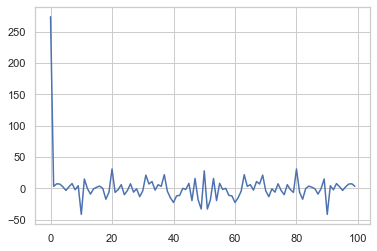

In [18]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

Some observations—
* The first value is unusually high. This is called as ‘DC component’ or ‘DC offset’ in electrical terminology.
* The wave signal is symmetric about the centre.

These observations are not peculiar to this particular window, but if you take any window from our time domain data and apply FFT on top of it, you will get same observations.
Don’t bother much about the DC component, think of it as an unusually high value that we are going to discard. Also we are going to consider only first half of the signal. This will ensure that we obtain unbiased statistical features from it.

Just like Stage 1, in the Stage 2 we shall construct new features by aggregating the fourier-transformed data —

In [19]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

By the end of the first 2 stages of feature engineering, we now have a total of 94 features! This brings us to the Stage 3 of feature engineering.

In [20]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,1.325941,9.866989,0.031191,1.621340,2.591918,1.965852,1.269607,1.659634,1.288883,-1.416516,...,1.975994,0.825269,4.585773,3.577126,0.100858,263.684952,671.809704,386.479445,31.293912,49.434694
1,2.329079,9.992704,-0.140017,2.086687,3.723214,2.664178,1.701726,3.094363,1.861259,-1.416516,...,3.561009,2.698166,0.857087,13.646833,7.697501,450.389098,1386.237857,716.940444,38.129355,61.516117
2,2.593314,9.971729,-0.143286,2.113932,3.690466,2.712587,1.778981,3.145450,1.924065,-1.307553,...,3.227962,3.032814,2.786292,12.760767,9.453052,447.477615,1362.116462,745.187706,37.577272,59.424006
3,2.700098,9.751897,-0.039090,1.966576,3.484772,2.593151,1.609773,2.956967,1.845099,-0.953424,...,3.485685,2.516479,2.881877,15.372249,7.233096,411.783473,1216.166921,673.086729,37.807214,60.424949
4,2.892008,9.750807,-0.169029,2.015529,3.375449,2.541830,1.624766,2.851284,1.723838,-0.612916,...,3.620969,2.736626,3.335036,15.926169,7.965116,408.736293,1141.418981,646.373555,35.951948,58.050047


In [21]:
X_train.shape

(16086, 94)

### Feature Engineering Stage 3: Capturing indices

The main goal of the feature engineering stage in any machine learning problem is to provide as much possible information to the model. More information you provide, better it learns!
So here in this case, why not take a look at index values of the underlying data as potential features?

In [22]:
# Max Indices and Min indices 

# index of max value in time domain
X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

# index of max value in frequency domain
X_train['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_train['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])

In [23]:
X_train.shape

(16086, 112)

# X_test

In [24]:
x_list = []
y_list = []
z_list = []
test_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x-axis'].values[i: i + 100]
    ys = df_test['y-axis'].values[i: i + 100]
    zs = df_test['z-axis'].values[i: i + 100]
    label = stats.mode(df_test['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()


In [25]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_test['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_test['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

In [26]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [27]:
# Max Indices and Min indices 

# index of max value in time domain
X_test['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_test['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_test['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_test['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_test['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_test['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_test['x_arg_diff'] = abs(X_test['x_argmax'] - X_test['x_argmin'])
X_test['y_arg_diff'] = abs(X_test['y_argmax'] - X_test['y_argmin'])
X_test['z_arg_diff'] = abs(X_test['z_argmax'] - X_test['z_argmin'])

# index of max value in frequency domain
X_test['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_test['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_test['x_arg_diff_fft'] = abs(X_test['x_argmax_fft'] - X_test['x_argmin_fft'])
X_test['y_arg_diff_fft'] = abs(X_test['y_argmax_fft'] - X_test['y_argmin_fft'])
X_test['z_arg_diff_fft'] = abs(X_test['z_argmax_fft'] - X_test['z_argmin_fft'])

In [28]:
X_test.shape

(5619, 112)

Likewise, follow the same steps as above for transforming raw test dataframe df_test and extracting features from it to build the transformed test dataset i.e. X_test. I’m skipping this part in the article for the sake of brevity. The new X_test dataset will have int(281002/50)-1 = 5619 rows.

This brings us to the final section of this article. Now that we have generated so many features, its time to see how well can these newly handcrafted features predict the human activity.

# Implementing a Linear model for Activity Prediction

For the prediction task, we will be training a simple Logistic Regression model on the transformed train data and then evaluating the performance on transformed test data. The idea is, logistic regression being a linear classifier, it heavily relies upon the quality of the features in order to give good results. More distinctive information the features provide, better is the performance. Thus, if we are able to obtain better performance using logistic regression, then we can say that we have been successful in creating the right set of features.

### Logistic Regression model


In [29]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [30]:
# For logistic regression, it is recommended to first standardize the data.
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)

# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7342943584267664

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.60      0.73      0.66       579
     Jogging       0.80      0.94      0.87      1522
     Sitting       0.88      0.70      0.78       360
    Standing       0.98      0.28      0.44       323
    Upstairs       0.35      0.57      0.43       635
     Walking       0.92      0.71      0.80      2200

    accuracy                           0.73      5619
   macro avg       0.76      0.66      0.66      5619
weighted avg       0.79      0.73      0.74      5619



We managed to obtain overall accuracy of 73.42 % on the test data by using baseline logistic regression model on the engineered features. This is pretty good taking into consideration the fact that we just had 3 features of raw accelerometer data at the start. By using some complex classification models like tree-based ensembles, voting or stacking classifiers, there is a scope for the improvement in the accuracy and other performance metrics.

From the classification report it can be seen that the overall performance is quiet good for most of the activities. Although there is some difficulty in recognising the two stair climbing activities. This was kind of expected as these two are very similar activities. Let’s check the Confusion matrix.

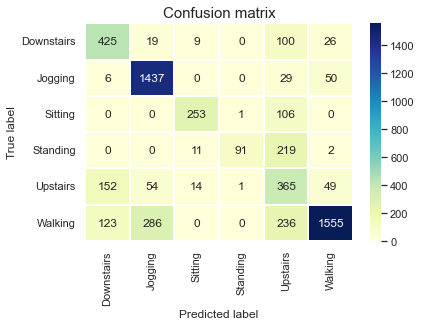

In [31]:

from sklearn.metrics import confusion_matrix
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

From the Classification report and Confusion matrix, it can be observed that Jogging and Walking, the two most common classes in our dataset are correctly identified with good accuracy. Although there are very few samples of Sitting and Standing classes, we can still identify these activities quite well, because the two activities cause the device to change orientation and this is easily detected from the accelerometer data. To more accurately differentiate between Upstairs and Downstairs activties, the existing set of features are not enough. By coupling the tri-axial accelerometer data with the data from tri-axial gyroscope (another inertial sensor in smart devices), it can be possible to distinguish between these classes as well as recognize other activities with greater accuracy.

# Modelling - Training LSTM Network


### Data Preprocessing


In [32]:
!pip install --upgrade protobuf

In [33]:
import re
from keras import Sequential, models
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [34]:
RANDOM_SEED = 24    
N_TIME_STEPS = 50   # 50 records in each sequence
N_FEATURES = 3      # x, y, z
step = 10           # window overlap = 50 -10 = 40  (80% overlap)
N_CLASSES = 6       # class labels
N_EPOCHS = 50       
BATCH_SIZE = 1024   
LEARNING_RATE = 0.0025
L2_LOSS = 0.0015

LSTM model expects fixed-length sequences as training data. Each generated sequence contains 50 training samples.



In [35]:
# step = 10
# N_TIME_STEPS = 50 
segments = []
labels = []

for i in range(0,  df_sorted.shape[0]-N_TIME_STEPS, step):  
    xs = df_sorted['x-axis'].values[i: i + 50]
    ys = df_sorted['y-axis'].values[i: i + 50]
    zs = df_sorted['z-axis'].values[i: i + 50]
    label = stats.mode(df_sorted['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to one list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
reshaped_segments.shape

(108531, 50, 3)

sanity check: 1085360 - 50 = 1085310 || 1085310/10 = 108531

Training dataset has reduced in size after the transformation. Note that the most common activity in a sequence is assigned as a label for the sequence.

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [38]:
X_train.shape[0]

16086

In [39]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(86824, 50, 3) (86824, 6)
(21707, 50, 3) (21707, 6)


In [40]:
# LSTM model

epochs = 50
batch_size =  1024

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape= (X_train.shape[1], X_train.shape[2]))) # input_shape = 50, 3
# Dropout layer
model.add(Dropout(0.4)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


Beacuse of so many trainable paraemter, the model tend to overfit easily. That is why a dropout layer is recommended to avoid overfitting.



## Training and Validation


In [42]:
# Training
history = model.fit(X_train, y_train, epochs = epochs, 
                    validation_split = 0.25, batch_size = batch_size, verbose = 1)

Epoch 1/50
64/64 [==============================] - 22s 34ms/step - loss: 1.2136 - accuracy: 0.5701 - val_loss: 0.5693 - val_accuracy: 0.8007
Epoch 2/50
64/64 [==============================] - 1s 22ms/step - loss: 0.5597 - accuracy: 0.8078 - val_loss: 0.4804 - val_accuracy: 0.8267
Epoch 3/50
64/64 [==============================] - 1s 22ms/step - loss: 0.4931 - accuracy: 0.8272 - val_loss: 0.4417 - val_accuracy: 0.8358
Epoch 4/50
64/64 [==============================] - 1s 22ms/step - loss: 0.4469 - accuracy: 0.8374 - val_loss: 0.4021 - val_accuracy: 0.8466
Epoch 5/50
64/64 [==============================] - 1s 22ms/step - loss: 0.4047 - accuracy: 0.8521 - val_loss: 0.3669 - val_accuracy: 0.8617
Epoch 6/50
64/64 [==============================] - 1s 22ms/step - loss: 0.3626 - accuracy: 0.8659 - val_loss: 0.3404 - val_accuracy: 0.8674
Epoch 7/50
64/64 [==============================] - 1s 22ms/step - loss: 0.3318 - accuracy: 0.8765 - val_loss: 0.2995 - val_accuracy: 0.8872
Epoch 8/50
6

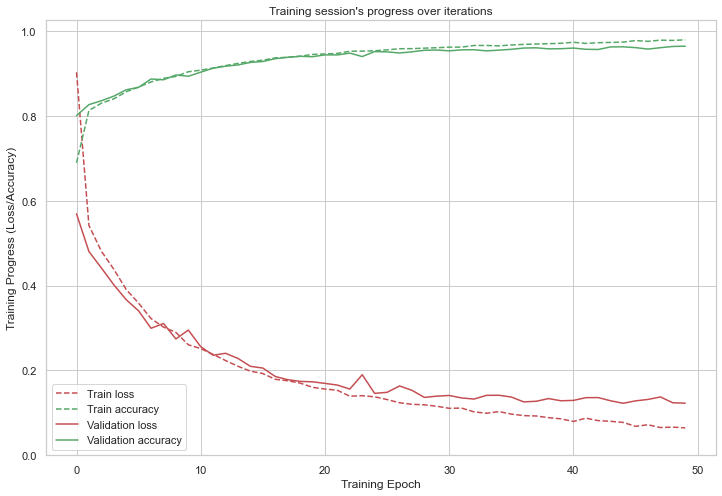

In [43]:
# Train and Validation: multi-class log-Loss & accuracy plot

plt.figure(figsize=(12, 8))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

### Model performance on Test data


In [44]:
# Test data loss & accuracy

loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("")
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 0s 8ms/step - loss: 0.1318 - accuracy: 0.9623

Test Accuracy : 0.9622702598571777
Test Loss : 0.13183756172657013


### Confusion matrix

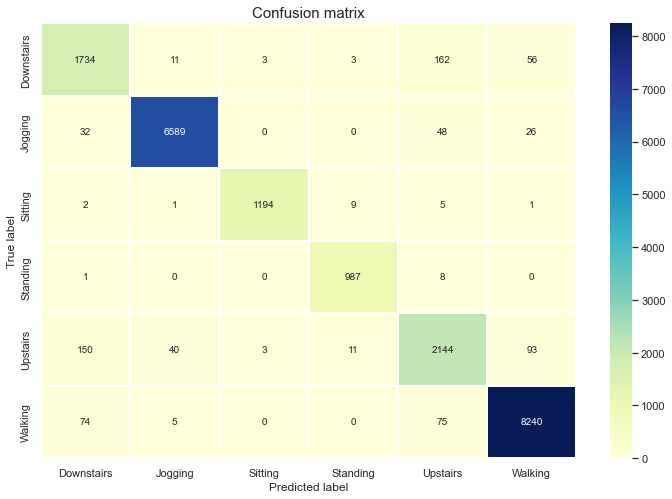

In [45]:
# Confusion Matrix

predictions = model.predict(X_test)
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,
            linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Recall matrix


In [46]:
new_array = []
for i in confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
recall_matrix = np.array(new_array).reshape(6, 6)

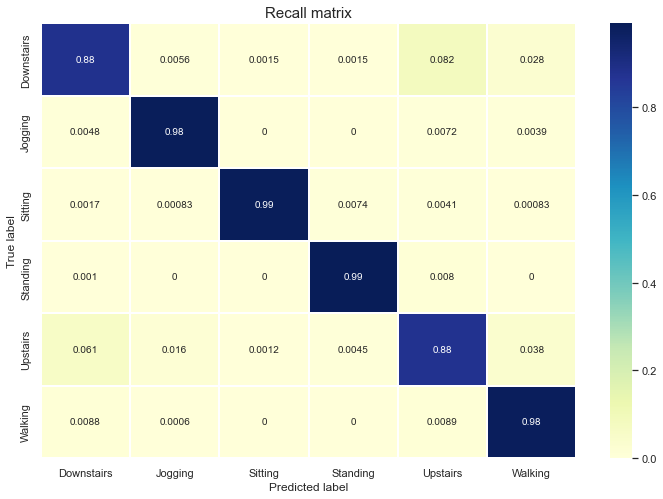

In [47]:
# Recall Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(recall_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot = True, cmap = 'YlGnBu')
plt.title('Recall matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Precision matrix


In [48]:
# Precision Matrix 

pr_confusion_matrix = np.transpose(confusion_matrix)
new_array = []
for i in pr_confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
pr_matrix = np.array(new_array).reshape(6, 6)
pr_matrix = np.transpose(pr_matrix)

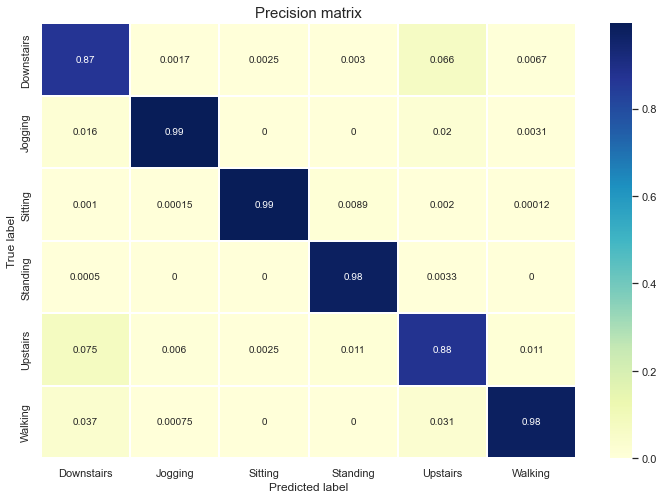

In [49]:
# Precision Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pr_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot=True, cmap = 'YlGnBu')
plt.title("Precision matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
# save model and architecture
from keras.models import load_model
model.save(mypath + 'har_model_50epochs.h5') 

with open(mypath + 'model_architecture.json', 'w') as f:
    f.write(model.to_json())

NameError: name 'mypath' is not defined